In [1]:
from qiskit import __version__
print(__version__)

1.4.2


In [145]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, Pauli
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error 
from qiskit.circuit.library import HGate, UnitaryGate
import matplotlib.pyplot as plt

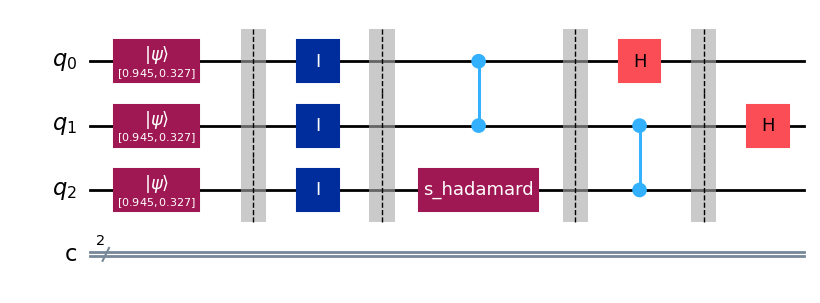

In [169]:
# Create a UnitaryGate with Hadamard matrix but custom label
H_matrix = HGate().to_matrix()
h_tagged = UnitaryGate(H_matrix, label='s_hadamard')

circuit = QuantumCircuit(3, 2)

# State prep
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

for i in range(3):
    circuit.initialize([amp_0, amp_1], i)
circuit.barrier()

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.append(h_tagged, [2])
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.cz(1,2)
circuit.barrier()

# Measure qubit 1 in X basis 
circuit.h(1)

display(circuit.draw(output='mpl'))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



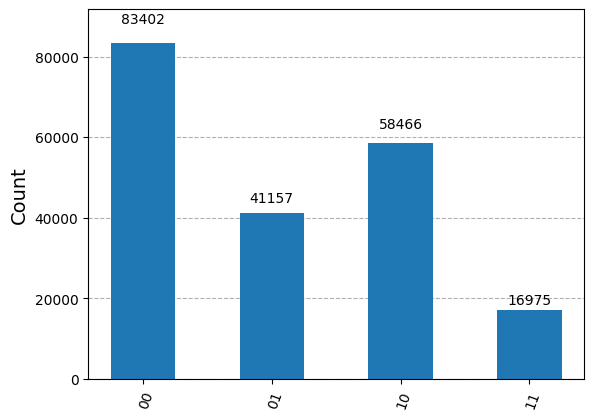

In [170]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['s_hadamard'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2),['cz'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [0])
noise_model.add_readout_error(readout_err, [1])


meas_circuit_noise = circuit.copy()
meas_circuit_noise.measure([0, 1], [0, 1])

meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

backend = AerSimulator(noise_model=noise_model)

transpiled = transpile(meas_circuit_noise, backend)

job = backend.run(transpiled,shots=200000)
result = job.result()
print(result)

counts_noise = result.get_counts()
display(plot_histogram(counts_noise)) 

In [171]:
res_statevectors = result.data()['state_post']

target_amplitudes = Statevector([
    0.94502682+1.41221240e-15j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.32699283+5.19195734e-16j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2))

correct = 0
for value in res_statevectors['0x0']:
    if target_amplitudes == value:
        correct += 1
meas00 = len(res_statevectors['0x0']) 

print(f"Number of correct outputs measuring '00': {correct}")
print(f"Number of outputs measuring '00': {meas00}")

Number of correct outputs measuring '00': 74051
Number of outputs measuring '00': 83402


In [172]:
# Calculating the average state of all 00 measurement outcomes
average = np.zeros(8, dtype=complex)

for shot in res_statevectors['0x0']:
    average += shot.data
    
average /= np.linalg.norm(average)
average_state = Statevector(average)
#display(average_state.draw("latex"))


ideal = Statevector([0.94502682+4.48585114e-15j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.32699283+1.72372984e-15j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2))
#display(ideal.draw("latex"))

fidelity = state_fidelity(ideal, average_state)
print(fidelity)

0.9980799268597373


# Keeping the Readout Error constant but changing the depolarizing noise

In [173]:
depol_probs = [] 
i = 0 
while i <= 0.1:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*10, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

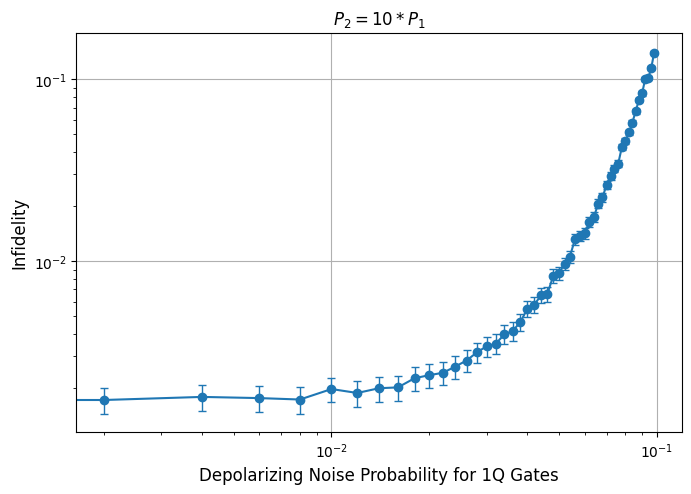

In [174]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [175]:
depol_probs = [] 
i = 0 
while i <= 0.09:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*11, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

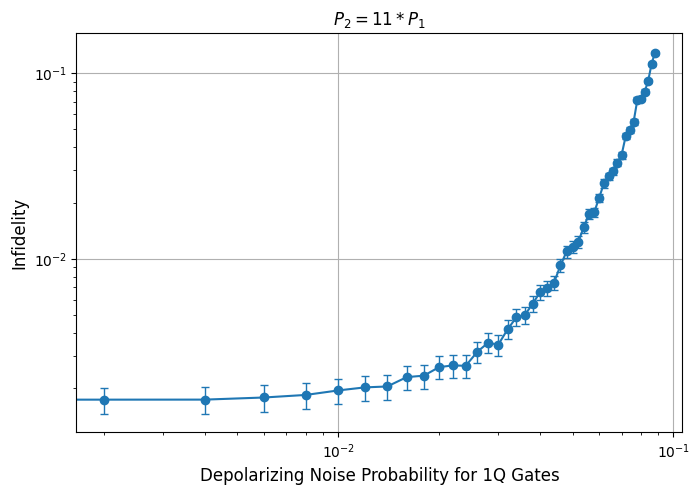

In [176]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 11 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [177]:
depol_probs = [] 
i = 0 
while i <= 0.08:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*12, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

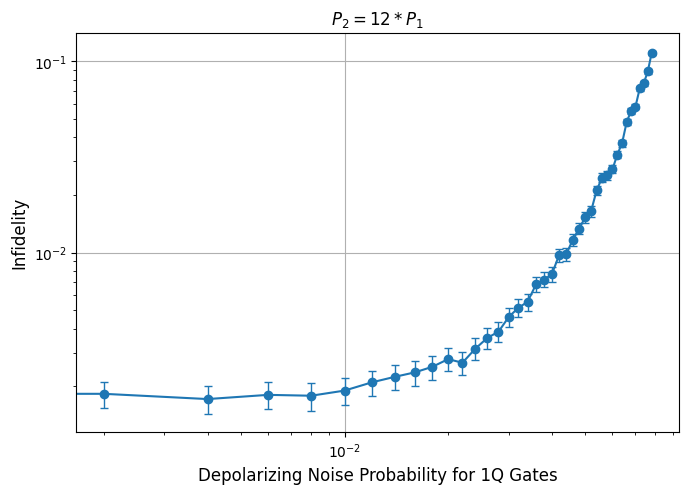

In [178]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 12 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [179]:
depol_probs = [] 
i = 0 
while i <= 0.076:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*13, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

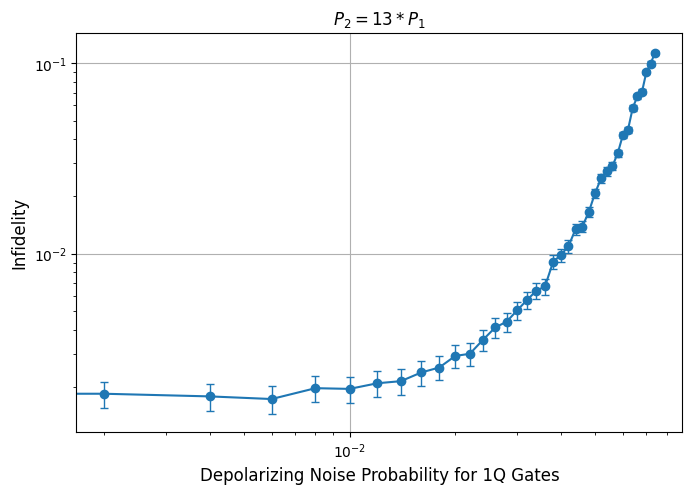

In [180]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 13 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [181]:
depol_probs = [] 
i = 0 
while i <= 0.07:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*14, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

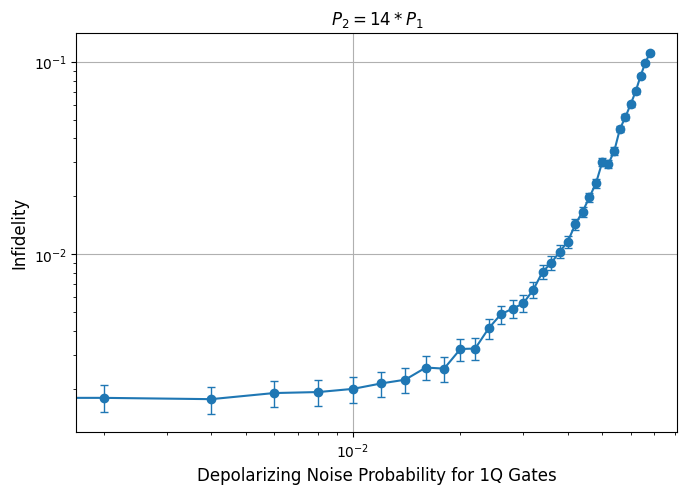

In [182]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 14 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [183]:
depol_probs = [] 
i = 0 
while i <= 0.066:
    depol_probs.append(round(i, 3))
    i += 0.002
fidelity_results = {}
sample_err_rate = []

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p*15, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
    meas00 = len(res_statevectors['0x0']) 
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid
    
    # Calculating error rate for uncertainty calculations
    sample_err_rate.append((fid)*(1 - fid) / meas00)

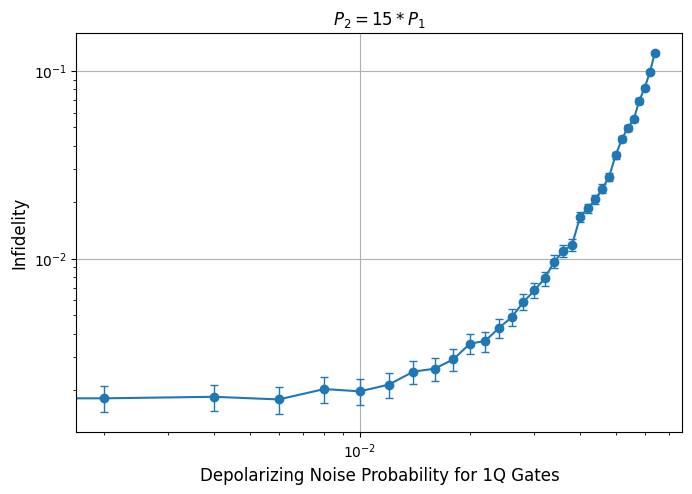

In [184]:
depol_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in depol_probs]

# Uncertainty Calculations
unc = [1.96 * np.sqrt(i) for i in sample_err_rate]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 15 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Pauli Errors

In [185]:
noise_model = NoiseModel()

pauli_probs = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2] 
fidelity_results = {}

readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

ideal = Statevector([0.94502682+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.32699283+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))

for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 2*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id', 'h_targeted'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid

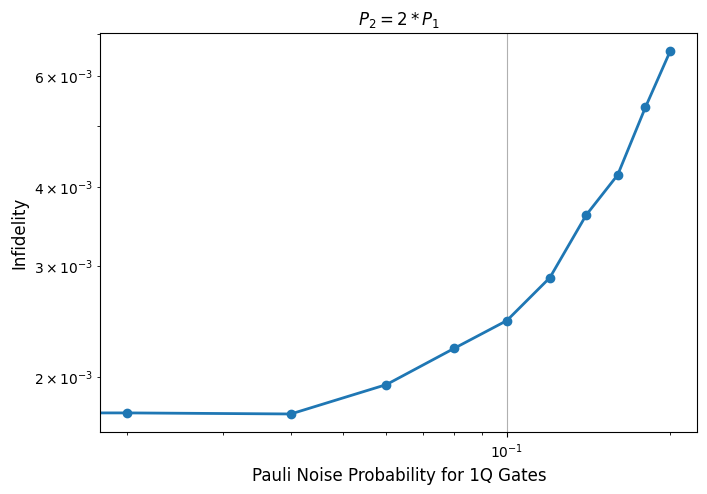

In [186]:
pauli_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in pauli_probs]

plt.figure(figsize=(7, 5))
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 2 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [187]:
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 3*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id', 'h_targeted'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid

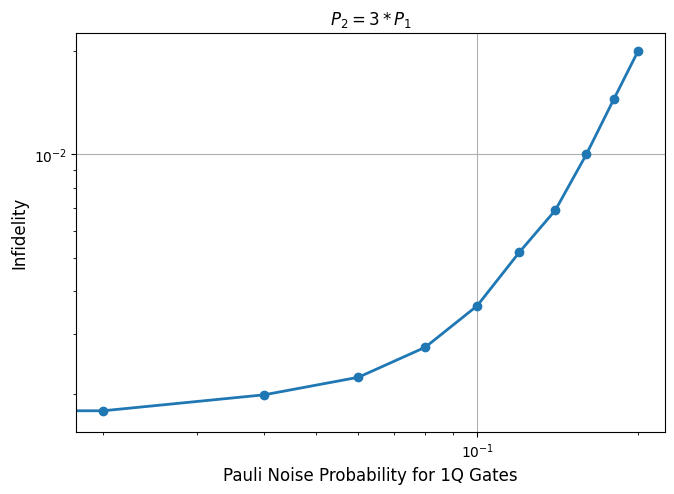

In [188]:
pauli_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in pauli_probs]

plt.figure(figsize=(7, 5))
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 3 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [189]:
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 5*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id', 'h_targeted'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend)
    job = backend.run(transpiled, shots=200000)
    result = job.result()
    
    # Extract final state and compute fidelity 
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)
    
    fidelity_results[p] = fid

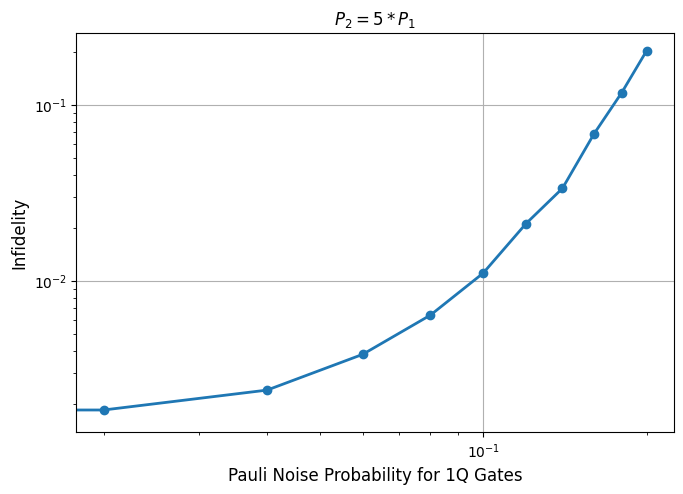

In [190]:
pauli_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in pauli_probs]

plt.figure(figsize=(7, 5))
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 5 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()